<a href="https://colab.research.google.com/github/szilarderik/MI-laborok/blob/main/ASR_Practice_11_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.&nbsp;Copyright

The objectives of this notebook: Use the DTW algorithm to find test sentences with similar content from sample sentences

In [1]:
## Install dependencies
!pip install sounddevice wavio ipywebrtc ffmpeg-python librosa dtw matplotlib notebook

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5300 sha256=0907e3b2e61d7d7d371059428e630275fcdd246cb9a80e7438a012b52e3b7496
  Stored in directory: /root/.cache/pip/wheels/71/31/62/5e67f6e31521b8cc1652aa58b1ed0c892514d01eeee85fd49c
Successfully built dtw


In [2]:
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import display, Audio
from ipywidgets import widgets
import librosa
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from numpy.linalg import norm
import ffmpeg
import os

Support for third party widgets will remain active for the duration of the session. To disable support:

In [19]:
from google.colab import output
output.enable_custom_widget_manager()

In [20]:
!pip install notebook ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


# Introduction to Dynamic Time Warping (DTW)

**Dynamic Time Warping (DTW)** is a family of algorithms that compute the local stretching or compression needed to align the time axes of two time series. This alignment maps one time series (query) onto the other (reference) in an optimal way.

DTW provides two main outputs:
1. **Cumulative Distance**: The total cumulative distance between the two time series.
2. **Warping Function**: (Optional) The mapping that shows how the query aligns with the reference.

---

### Applications
DTW is widely used in various fields, including:

#### **Speech and Audio Processing**
- Speaker Verification: Aligning spoken utterances for speaker matching.
- Keyword Spotting: Matching a query audio snippet against a reference.
- Speech Recognition: Comparing speech patterns for phoneme or word alignment.
- Music Processing: Aligning musical pieces with tempo variations for synchronization or analysis.

#### **Econometrics**
- Time Series Classification: Grouping and categorizing financial or economic data.
- Clustering: Finding similarities in time-dependent variables.

#### **General Time Series Mining**
- Applied in diverse domains for pattern matching and similarity analysis.


In [21]:
# Define a function to record audio samples
def record_sample(label, sample_index):
    """
    Record an audio sample
    :param label: Sample label
    :param sample_index: Sample index
    """
    camera = CameraStream(constraints={'audio': True, 'video': False})
    recorder = AudioRecorder(stream=camera)

    # Display recording controls
    display(widgets.HTML(f"<h4>Recording sample {sample_index}: {label}</h4>"))
    display(recorder)

    def save_recording(change):
        filename = f"sample_{sample_index}.webm"
        with open(filename, "wb") as f:
            f.write(recorder.audio.value)

        # Use ffmpeg to convert the recording to WAV format
        output_filename = f"sample_{sample_index}.wav"
        ffmpeg.input(filename).output(output_filename, ac=1).run(overwrite_output=True)
        os.remove(filename)  # Remove the temporary file

        print(f"Sample {sample_index} saved as {output_filename}")

    # Observe the save event for the recording
    recorder.audio.observe(save_recording, names="value")

In [22]:
# Define a function to record query sentences
def record_query():
    """
    Record query audio
    """
    camera = CameraStream(constraints={'audio': True, 'video': False})
    recorder = AudioRecorder(stream=camera)

    # Display recording controls
    display(widgets.HTML("<h4>Recording query sentence...</h4>"))
    display(recorder)

    def save_recording(change):
        filename = "query.webm"
        with open(filename, "wb") as f:
            f.write(recorder.audio.value)

        # Use ffmpeg to convert the recording to WAV format
        output_filename = "query.wav"
        ffmpeg.input(filename).output(output_filename, ac=1).run(overwrite_output=True)
        os.remove(filename)  # Remove the temporary file

        print("Query audio saved as query.wav")

    # Observe the save event for the recording
    recorder.audio.observe(save_recording, names="value")


## MFCC (Mel-Frequency Cepstral Coefficients)

**Mel-Frequency Cepstral Coefficients (MFCCs)** are widely used features in speech and audio processing. They provide a compact representation of the power spectrum of an audio signal based on human auditory perception.

---
### **Why Use MFCC?**
- **Compact Representation**:
  - Reduces the audio data size while retaining critical features.
  - Makes further processing faster and more efficient.
---

### **Applications**
- **Speech Recognition**: Capture phoneme-level features.
- **Speaker Identification**: Model vocal tract characteristics.
- **Audio Classification**: Analyze sound patterns in music or noise.

In [23]:
# Extract MFCC features from audio
def compute_mfcc(audio_path):
    """
    Extract MFCC features from audio
    :param audio_path: Path to the audio file
    :return: MFCC features
    """
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc


In [24]:
# Compute and visualize the relationship between the query sentence and sample sentences
def compute_and_visualize_query_dtw(sample_files, query_file, labels):
    """
    Compute and visualize DTW distances between the query sentence and sample sentences
    :param sample_files: List of sample audio file paths
    :param query_file: Query audio file path
    :param labels: List of sample labels
    """
    print("\nComputing DTW distances between query and samples...")
    query_distances = []
    query_label = "Query Audio"
    query_mfcc = compute_mfcc(query_file)

    # Dynamically calculate subplot layout
    n = len(sample_files)
    rows = (n + 4) // 5  # Maximum 5 subplots per row
    plt.figure(figsize=(15, rows * 5))

    for i, sample_file in enumerate(sample_files):
        sample_mfcc = compute_mfcc(sample_file)

        # Compute DTW between query and sample
        dist, cost, acc_cost, path = dtw(
            query_mfcc.T, sample_mfcc.T, dist=lambda x, y: norm(x - y, ord=1)
        )
        query_distances.append(dist)

        # Visualize the DTW path between query and sample
        plt.subplot(rows, 5, i + 1)
        plt.imshow(cost.T, origin="lower", cmap="gray", interpolation="nearest")
        plt.plot(path[0], path[1], "r")
        plt.title(f"{query_label} ↔ {labels[i]}\nDTW: {dist:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Print DTW distances between query and samples
    print("DTW Distances (Query vs Samples):")
    for i, dist in enumerate(query_distances):
        print(f"{query_label} ↔ {labels[i]}: {dist:.2f}")

    return query_distances


In [36]:
# ============ Step 3: Run Recording and Analysis Workflow ============ #

# Define sample labels
sample_labels = ["Hello World", "How are you?", "I love programming", "Speech recognition", "Python is awesome"]
sample_files = []

# Record five samples
for i, label in enumerate(sample_labels, start=1):
    print(f"Recording sample {i}: {label}")
    record_sample(label, i)
    sample_files.append(f"sample_{i}.wav")

# Record the query sentence
print("Recording query sentence...")
record_query()


Recording sample 1: Hello World


HTML(value='<h4>Recording sample 1: Hello World</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Recording sample 2: How are you?


HTML(value='<h4>Recording sample 2: How are you?</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Recording sample 3: I love programming


HTML(value='<h4>Recording sample 3: I love programming</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Recording sample 4: Speech recognition


HTML(value='<h4>Recording sample 4: Speech recognition</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Recording sample 5: Python is awesome


HTML(value='<h4>Recording sample 5: Python is awesome</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Recording query sentence...


HTML(value='<h4>Recording query sentence...</h4>')

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

Sample 1 saved as sample_1.wav
Sample 2 saved as sample_2.wav
Sample 3 saved as sample_3.wav
Sample 4 saved as sample_4.wav
Sample 5 saved as sample_5.wav
Query audio saved as query.wav


Computing DTW between query and samples...

Computing DTW distances between query and samples...


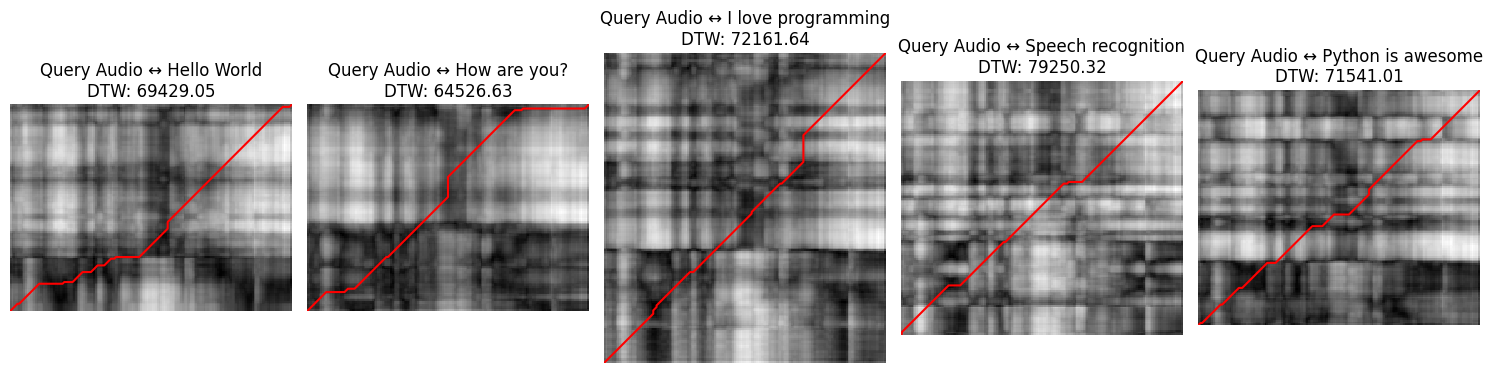

DTW Distances (Query vs Samples):
Query Audio ↔ Hello World: 69429.05
Query Audio ↔ How are you?: 64526.63
Query Audio ↔ I love programming: 72161.64
Query Audio ↔ Speech recognition: 79250.32
Query Audio ↔ Python is awesome: 71541.01
DTW Distances (Query vs Samples):
Query ↔ Hello World: 69429.05
Query ↔ How are you?: 64526.63
Query ↔ I love programming: 72161.64
Query ↔ Speech recognition: 79250.32
Query ↔ Python is awesome: 71541.01


In [37]:
# Compute the relationship between the query sentence and sample sentences, and visualize
print("Computing DTW between query and samples...")
query_distances = compute_and_visualize_query_dtw(sample_files, "query.wav", sample_labels)

# Print DTW distances between the query sentence and samples
print("DTW Distances (Query vs Samples):")
for i, dist in enumerate(query_distances):
    print(f"Query ↔ {sample_labels[i]}: {dist:.2f}")



In [38]:
# Infer the lable of "Query Audio"

min_distance = min(query_distances)
min_index = query_distances.index(min_distance)
predicted_label = sample_labels[min_index]

print("\nPredicted Label for Query Sentence:")
print(f"Query Audio: {predicted_label}")


Predicted Label for Query Sentence:
Query Audio: How are you?


In [ ]:
### YOUR TASK:
# Task 1: Try to make the sample and query recordings come from the same person,
# observe the recognition effect of the DTW algorithm.

# Task 2: Two people work together, try to make the sample recordings come from one person,
# the query comes from another person,
# observe the recognition effect of the DTW algorithm.

In [ ]:
### this is the end of the ASR notebook